# Рынок заведений общественного питания Москвы

Решено открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Инвесторов интересует текущее положение дел на рынке — сможет ли кафе снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов? 

Исследуем рынок. У нас есть открытые данные о заведениях общественного питания в Москве.

Импорт необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

#pd.set_option('display.max_rows', None)

## Загрузка данных и подготовка к анализу

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/rest_data.csv')
data

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


### Общая информация

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
data.describe()

,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


In [5]:
print('Пропуски:') 
print()
print(data.isna().sum())

Пропуски:

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


**Выводы:**

1. Типы данных верные.
2. Пропуски отсутствуют.
3. Аномальные значения в столбца "id"(отрицательные значения) и "number"(отрицательные значения, слишком большие) отсутствуют.

### Проверка дубликатов

Проверю уникальные значения по столбцам По с, 'chain', 'object_type', 'address'

In [6]:
print("Уникальные значения по столбцам и их количество:")
print()
print("Столбец object_name:")
print(data['object_name'].value_counts())
print()
print("Столбец chain:")
print(data['chain'].value_counts())
print()
print("Столбец object_type:")
print(data['object_type'].value_counts())
print()
print("Столбец address:")
print(data['address'].value_counts())

Уникальные значения по столбцам и их количество:

Столбец object_name:
Столовая                     267
Кафе                         236
Шаурма                       234
KFC                          155
Шоколадница                  142
                            ... 
Роял                           1
Кофейня Даблби                 1
СТ.ШК. 1104 «ШКОЛЬНИК-ЮЗ»      1
Византий                       1
Кафе Гурмэ                     1
Name: object_name, Length: 10393, dtype: int64

Столбец chain:
нет    12398
да      2968
Name: chain, dtype: int64

Столбец object_type:
кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Столбец address:
г

По столбцу 'object_name' есть повторяющиеся названия заведений записанные разными способами, по наиболее популярным заведениям приведу названия к единому формату в несколько шагов:

Шаг 1. Приведу все значения в столбце к нижнему регистру:

In [7]:
data['object_name'] = data['object_name'].str.lower() 

Шаг 2. Заменю символы кавычек и апострофы, а также типы заведений из названий на "ничего":

Для удобства дальнейших исследований заменю "предприятие быстрого обслуживания" на "фастфуд" и "магазин (отдел кулинарии)" на "кулинария".

In [8]:
data['object_name'] = data['object_name'].str.replace('«', '', regex=True)
data['object_name'] = data['object_name'].str.replace('»', '', regex=True)
data['object_name'] = data['object_name'].str.replace("'", '', regex=True)
data['object_name'] = data['object_name'].str.replace('ё', 'е', regex=True)
data['object_name'] = data['object_name'].str.replace('ресторан ', '', regex=True)
data['object_name'] = data['object_name'].str.replace('кафе ', '', regex=True)
data['object_type'] = data['object_type'].str.replace('предприятие быстрого обслуживания', 'фастфуд', regex=True)
data['object_type'] = data['object_type'].str.replace('магазин \(отдел кулинарии\)', 'кулинария', regex=True)

Промежуточные результаты уже видны :)

In [9]:
print("Столбец object_name:")
print(data['object_name'].value_counts())

Столбец object_name:
столовая              323
кафе                  279
шаурма                252
шоколадница           176
kfc                   171
                     ... 
максимус                1
гамма лайт              1
сметана                 1
сладкомания             1
столовая школы 924      1
Name: object_name, Length: 9449, dtype: int64


Шаг 3. Создам словари синонимов, которые позволяет мне заменить варианты названий заведений на одно значение:

In [10]:
synonyms = {'mcdonalds': ['макдоналдс', 'ресторан макдоналдс'], 
            'kfc': ['ресторан kfc','кфц', 'ростикс kfc', 'kfc волгоградский', 'kfc.', 'закусочная kfc', 'кафе kfc', 'ресторан kfc', 'пбо kfc покрышкина', 'пбо kfc'], 
            'dominos pizza': ["'домино'с пицца", 'domino-s pizza', "ресторан домино'с пицца", "домино'с пицца", "доминос пицца"], 
            'бургер кинг': ['бургер кинг burger king', 'burger king', 'кафе бургер кинг', 'ресторан бургер кинг', 'закусочная бургер кинг'], 
            'starbucks': ['starbucks кофе','starbucks старбакс','starbucks coffee', 'старбакс кофе', 'старбакс', 'старбакс starbucks'],
            'il patio': ['il патиопланета суши','il патио', 'иль патио', 'иль патио планета суши', 'ресторан иль патио'],
            'шоколадница':['шоколадница кофе xаус', 'шоколадница кофемания', 'шоколадница экспресс'],
            'хинкали gали':['хинкали gali', 'хинкали-gали','хинкали-гали'],
            'суши wok':['суши вок'],
            'стардогс': ['стардогс стардогs', 'стардогs', 'стардогs', 'стардогs и шаурма', 'закусочная стардогs'],
            'subway': ['сабвей сушивок', 'сабвей subway','сабвэй','сабвей'],
            'самарканд': ['самарканд-сити'],
            'прайм': ['прайм стар', 'прайм стар кафе', 'прайм-кафе','прайм-кафе', 'прайм стар','праймкафе прайм стар','праймстар','праймстар ресторантс групп'],
            'правdа кофе': ['правда кофе'],
            'пиццерия додо':['пиццерия додо пицца', 'додо пицца','додопицца', 'до до пицца'],
            'pizza hut': ['пицца хат'],
            'пиццерия папа джонс': ['папа джонс пицца', 'папа джонс'],
                       }
def check_synonyms(cell):
    for name, syn in synonyms.items():
        if cell in syn:
            return name
    return cell
data['odject_name_new'] = data['object_name'].apply(check_synonyms)

print("Столбец object_name:")
print(data['odject_name_new'].value_counts())

Столбец object_name:
столовая              323
кафе                  279
шаурма                252
kfc                   186
шоколадница           178
                     ... 
билла                   1
человек и пароход       1
роддом 17 пищеблок      1
vlofte                  1
столовая школы 924      1
Name: odject_name_new, Length: 9400, dtype: int64


In [11]:
print("Всего дублирующихся строк в таблице:", data.duplicated().sum())

Всего дублирующихся строк в таблице: 0


**Выводы:**

1. Названия самых популярных и наиболее часто встречащихся в нашем датафрейме заведений иземенены.
2. Дубликаты строк отсутствуют.

## Анализ данных.

### Исследую соотношение видов объектов общественного питания по количеству:

Сгруппирую заведения по типу и найду их количество:

In [12]:
data_type = data.groupby('object_type').count().sort_values(by = 'id', ascending = False).reset_index()

Построю график:

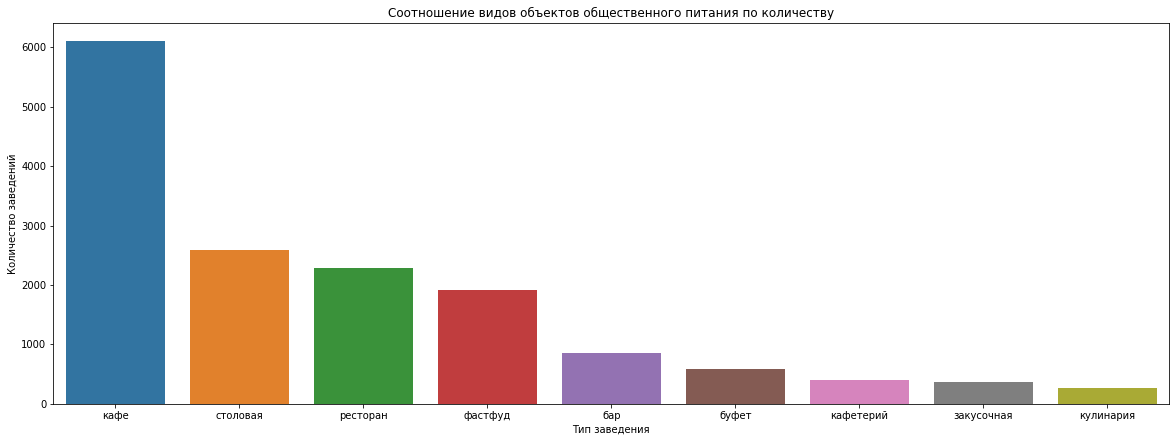

In [13]:
plt.figure(
    figsize=(20, 7))
ax = sns.barplot(x='object_type', y="id", data=data_type) 
ax.set(xlabel = 'Тип заведения', ylabel ='Количество заведений', 
       title='Соотношение видов объектов общественного питания по количеству')
plt.show()

**Выводы:**

Кафе почти в 2.5 раза больше, чем столовых.
Также в топе столовые, рестораны и фастфуд.

Остальных заведений гораздо меньше

### Исследую соотношение сетевых и несетевых заведений по количеству:

Посчитаю количество сетевых/несетевых заведений:

In [14]:
data_chain = data.groupby('chain').count()

Построю график:

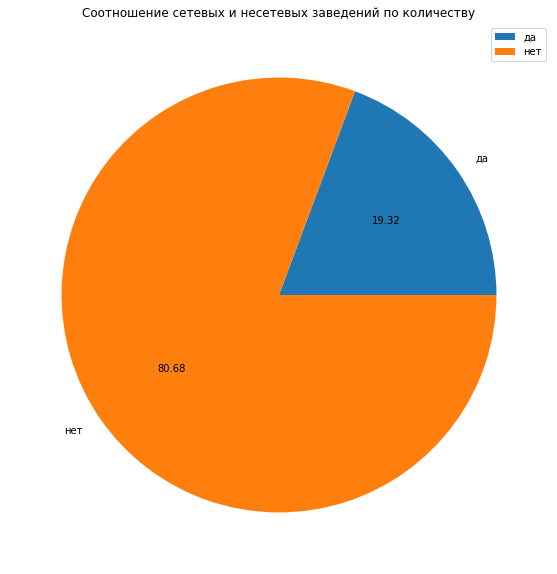

In [15]:
ax = data_chain.plot(kind = 'pie', x = 'chain', y='id', figsize=(15, 10),
                     title = 'Cоотношение сетевых и несетевых заведений по количеству', autopct="%.2f")
ax.set_ylabel('')
plt.show()

**Выводы:**

Несетевых заведений в 4 раза больше.

### Для какого вида объекта общественного питания характерно сетевое распространение?

Выделю из датафрейма все сетевые заведения

In [16]:
chain_yes = data.query('chain == "да"')

Построю график:

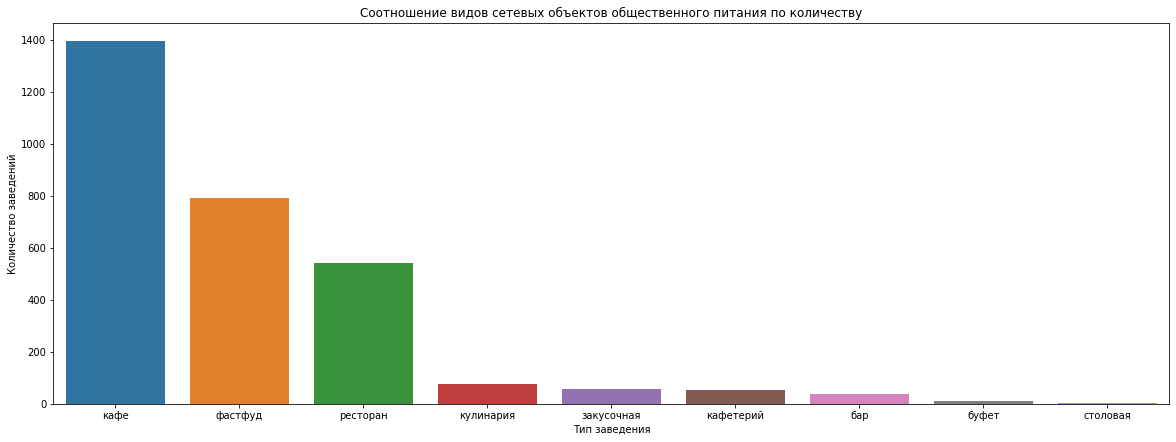

In [17]:
chain_yes_group = chain_yes.groupby('object_type').count().sort_values(by = 'address', 
                                                                                   ascending = False).reset_index()
plt.figure(
    figsize=(20, 7))
ax = sns.barplot(x='object_type', y ='address', data=chain_yes_group) 
ax.set(xlabel = 'Тип заведения', ylabel ='Количество заведений', 
       title='Соотношение видов сетевых объектов общественного питания по количеству')
plt.show()

Построю график количества заведений по типу в разрезах сетевое/несетевое заведение.

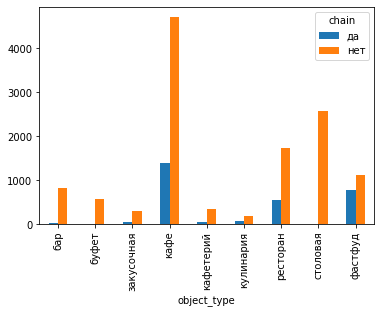

In [18]:
object_type_chain = data.pivot_table(index='object_type', values='id', columns='chain', aggfunc='count')
object_type_chain.plot(kind= 'bar')
plt.show()

In [19]:
chains_total = (((object_type_chain['да'] / (object_type_chain['да'] + object_type_chain['нет'])) * 100)
                   .reset_index())
chains_total.columns=['object_type','ratio']
chains_total.sort_values(by='ratio', inplace=True, ascending=False)
chains_total

,object_type,ratio
8,фастфуд,41.133645
5,кулинария,28.571429
6,ресторан,23.807440
3,кафе,22.888998
2,закусочная,15.555556
4,кафетерий,13.065327
0,бар,4.322430
1,буфет,1.880342
7,столовая,0.115964


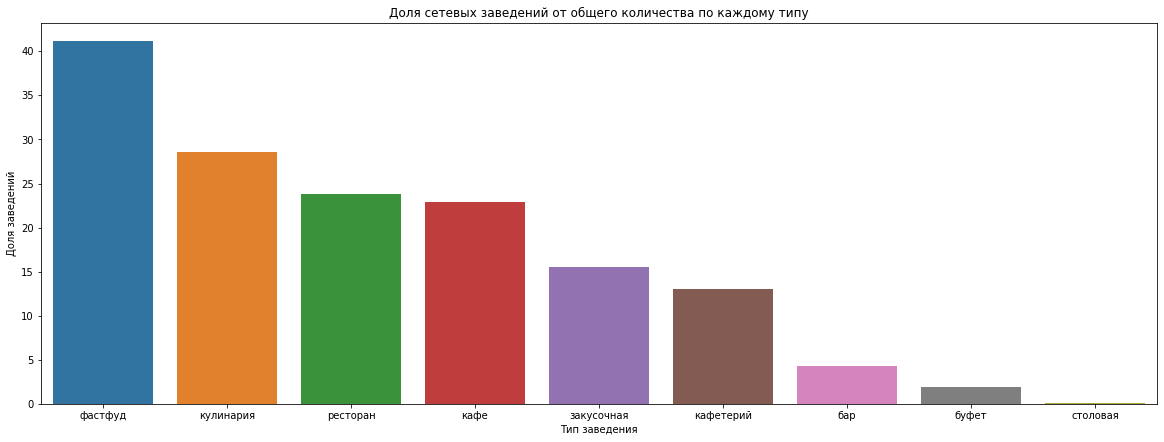

In [20]:
plt.figure(figsize=(20, 7))
ax = sns.barplot(x='object_type', y ='ratio', data=chains_total) 
ax.set(xlabel = 'Тип заведения', ylabel ='Доля заведений', title='Доля сетевых заведений от общего количества по каждому типу')
plt.show()

**Выводы:** 

Наиболее характерно сетевое распространение для фастфуда, кулинарии и ресторанов.



### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Сгруппирую сетевые места для подсчёта их количество и среднего числа посадочных мест:

In [21]:
chains = chain_yes.groupby('object_name').agg({'id': 'count', 'number': 'mean'})

Много сетевых заведений с числом заведений равным единице, при деление использую 75 перцентиль, а не медиану(если использовать медиану qcut не сработает).

По посадочным местам - медиану

In [22]:
chains['rest_group'] = pd.qcut(chains['id'], q = [0, 0.75, 1], labels =['Мало заведений', 'Много заведений'])
chains['num_group'] = pd.qcut(chains['number'], q = [0, 0.5, 1], labels = ['Мало мест','Много мест'])

Добавлю столбец с классификацией в исходный датафрейм:

In [23]:
chains['group'] = chains['rest_group'].astype(str) + ' - ' + chains['num_group'].astype(str)

Построю график:

(Text(0.5, 0, 'Количество заведений'),
 Text(0, 0.5, 'Среднее количество посадочных мест'))

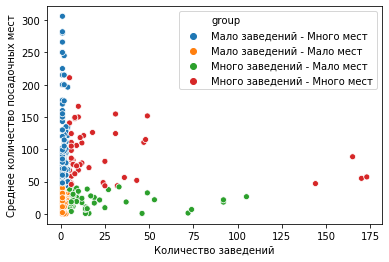

In [24]:
sns.scatterplot(x = 'id', y = 'number', hue = 'group', data = chains)
plt.xlabel('Количество заведений'), plt.ylabel('Среднее количество посадочных мест')

Сгруппирую сетевые заведения по типу объекта, найду количество объектов такого типа и среднее количество посадочных мест для объектов этого типа.

In [25]:
chains_number = chain_yes.groupby('object_type').agg({'id': 'count', 'number': 'mean'}).reset_index().sort_values(by = 'number', ascending = False)
chains_number

,object_type,id,number
7,столовая,3,112.333333
6,ресторан,544,100.233456
0,бар,37,53.027027
3,кафе,1396,47.426934
8,фастфуд,791,40.166877
2,закусочная,56,14.375000
1,буфет,11,12.727273
4,кафетерий,52,12.269231
5,кулинария,78,8.679487


Построю график:

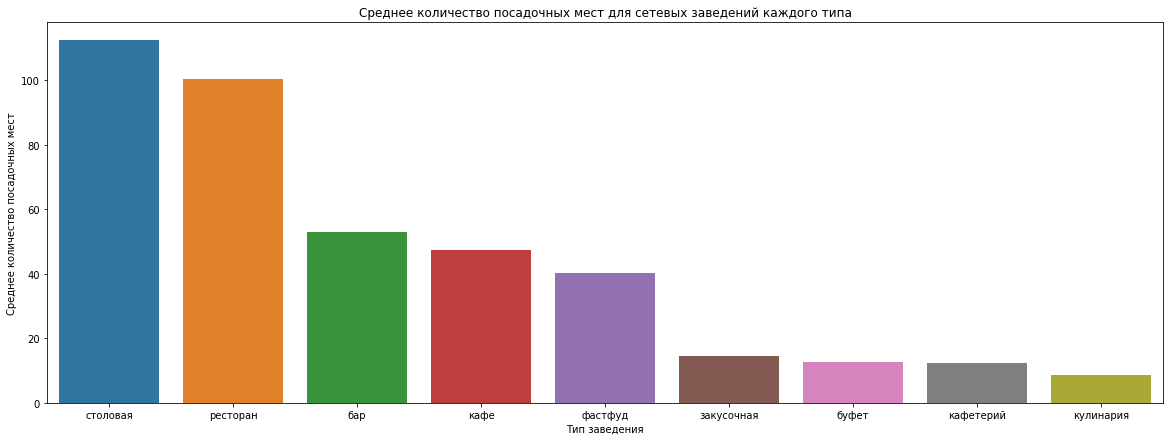

In [26]:
plt.figure(
    figsize=(20, 7))
ax = sns.barplot(x='object_type', y ='number', data=chains_number)
ax.set(xlabel = 'Тип заведения', ylabel ='Среднее количество посадочных мест', title='Среднее количество посадочных мест для сетевых заведений каждого типа')
plt.show()

**Выводы:**

Для сетевых заведений не характерно иметь много заведений и много мест, скорее всего это рестораны и столовые.
Много заведений и мало мест чаще всего в заведениях из категорий фастфуд и кулинария. 


### Cреднее количество посадочных мест для каждого вида объекта общественного питания.


Сгруппирую все заведения по типу для расчёта среднего количества посадочных мест:

In [27]:
data_type_num = data.groupby('object_type')[('number')].mean().sort_values(ascending = False).reset_index()
data_type_num

,object_type,number
0,столовая,130.246618
1,ресторан,96.834136
2,буфет,51.129915
3,бар,43.494159
4,кафе,39.716019
5,фастфуд,20.552262
6,кафетерий,9.123116
7,закусочная,7.608333
8,кулинария,5.589744


Построю график:

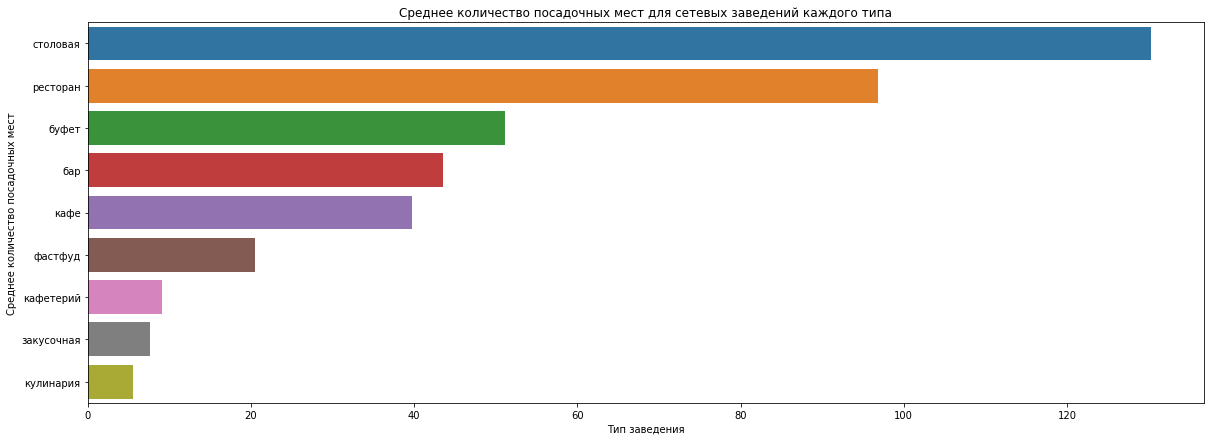

In [28]:
plt.figure(
    figsize=(20, 7))
ax = sns.barplot(x="number", y='object_type', data=data_type_num) 
ax.set(xlabel = 'Тип заведения', ylabel ='Среднее количество посадочных мест', title='Среднее количество посадочных мест для сетевых заведений каждого типа')
plt.show()

**Выводы:** 

Столовые и рестораны лидируют по среднему количеству посадочных мест - это очевидно.

Фастфуд, кафетерий, закусочная и кулинария не ориентированы на длительное времяпрепровождение в заведении, в них не требуется большое количество посадочных мест.

### Выделю в отдельный столбец информацию об улице из столбца address

Выделю в отдельный столбец улицу из адреса. Разобью адресс на состовляющие, через запятую методом split. 

Важно учитывать, что улица может находится на разных позициях и чтобы найти эту позицию:
1. Создам проверочный список со словами, которые будут явно указывать на то, что именно в этой части сразбитой строки указан улица. 
2. Проверю каждую из позиции в цикле на наличие этого слова. Если слово найдено, значит найдена улицу/проспект/площадь и т.п.

In [29]:
list_for_street = ['проспект', "площадь", "улица", "шоссе", 
                   "бульвар", 'переулок','набережная','проезд',
                   'тупик','микрорайон','территория','километр','посёлок','деревня'
                   ,'аллея','просек','линия','квартал','село','вблизи' ]
def get_street(row):
    address = row['address'].split(', ') 
    parts = len(address)
    try:
        for item in list_for_street:
            for i in range(parts):
                if item in address[i]:  
                    return address[i]
    except:
        return 'Error'
    
data['street'] = data.apply(get_street, axis=1)

In [30]:
data.head()

,id,object_name,chain,object_type,address,number,odject_name_new,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,24309,академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,академия,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица
4,119365,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,вишневая метель,Абрамцевская улица


Получилось :)

### Построю график топ-10 улиц по количеству объектов общественного питания. 

Сгруппирую датафрейм по названию улиц, посчитаю количество объектов на каждой улице:

In [31]:
top_10 = data.groupby('street')['object_name'].count().reset_index().sort_values(by = 'object_name',
                                                                                 ascending = False).head(10)
top_10

,street,object_name
1499,проспект Мира,204
1040,Профсоюзная улица,183
713,Ленинградский проспект,173
1024,Пресненская набережная,167
426,Варшавское шоссе,165
716,Ленинский проспект,148
1495,проспект Вернадского,132
703,Кутузовский проспект,114
626,Каширское шоссе,112
633,Кировоградская улица,110


Построю график:

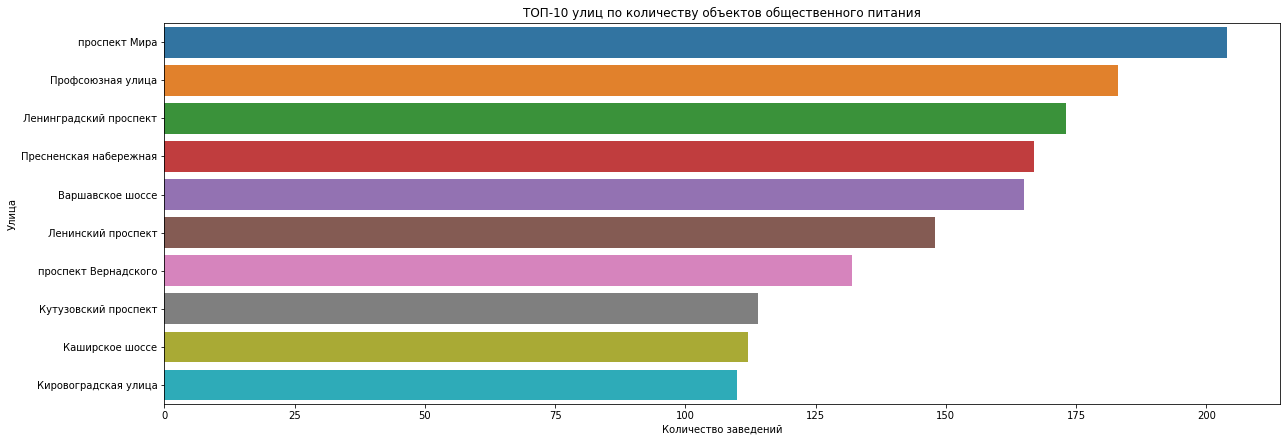

In [32]:
plt.figure(
    figsize=(20, 7))
ax = sns.barplot(x="object_name", y='street', data=top_10) 
ax.set(xlabel = 'Количество заведений', ylabel ='Улица', 
       title='ТОП-10 улиц по количеству объектов общественного питания')
plt.show()

**Выводы:**

Больше всего заведений находится на проспекте Мира.

### В каких районах Москвы находятся эти улицы?

Данные по районам города нашла в интернете и скопировала в Гугл таблицу, загружу данные в новый датафрейм

In [33]:
from io import BytesIO
import requests
spreadsheet_id = "1sguZSB8CeYCbCK2eMmsAlMkz9mBFw11GlyImzqJpjes"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df

,street,areaid,okrug,area
0,1-й Автозаводский проезд,98,ЮАО,Даниловский район
1,1-й Амбулаторный проезд,54,САО,Район Аэропорт
2,1-й Архивный переулок,20,ЦАО,Район Хамовники
3,1-й Бабьегородский переулок,21,ЦАО,Район Якиманка
4,1-й Балтийский переулок,54,САО,Район Аэропорт
...,...,...,...,...
4393,Яузская улица,18,ЦАО,Таганский район
4394,Яузский бульвар,18,ЦАО,Таганский район
4395,Яхромская улица,60,САО,Дмитровский район
4396,Яхромский проезд,58,САО,Район Восточное Дегунино


Объединю свою таблицу со справочником улиц 

In [34]:
rest_data = data.merge(df, on = 'street')

Так как одна улица может проходить через несколько районов, например, проспект Мира проходит через 9 районов, использую группировку по округу:

In [35]:
top_10_streets = top_10['street'].to_list()
top_10_count_on_district = rest_data.query('street == @top_10_streets')
top_10_count_on_district.pivot_table(index=['street', 'okrug'], values='id', aggfunc='count')

top_10_district = rest_data.groupby(['okrug','street']).agg({'id':'count'}).sort_values(by='id', 
                                                                                  ascending=False).head(10).reset_index()
top_10_district

,okrug,street,id
0,СВАО,проспект Мира,1224
1,ЮЗАО,Профсоюзная улица,1098
2,ЮАО,Варшавское шоссе,990
3,САО,Ленинградский проспект,692
4,ЮЗАО,Ленинский проспект,592
5,САО,Ленинградское шоссе,500
6,САО,Дмитровское шоссе,500
7,ЮАО,Каширское шоссе,448
8,ЗАО,проспект Вернадского,396
9,ЮВАО,Волгоградский проспект,378


Построю график:

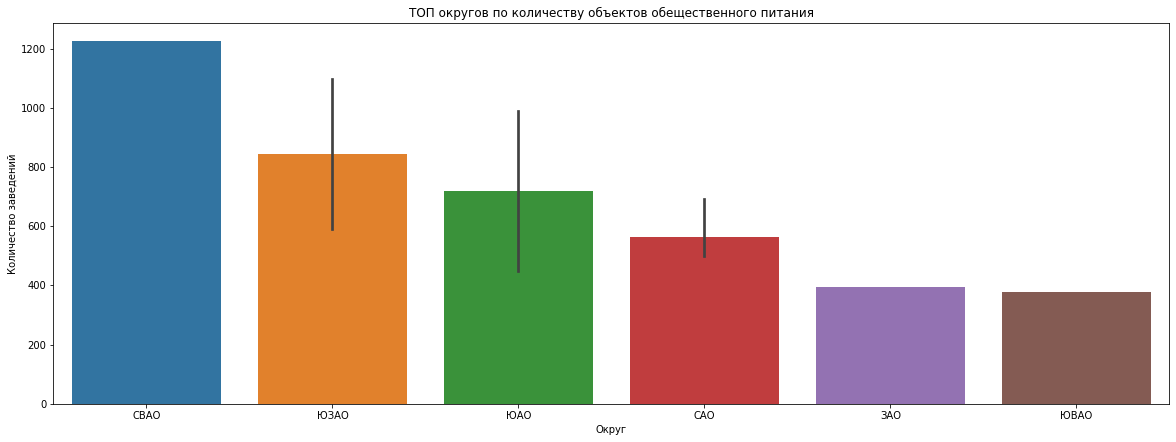

In [36]:
plt.figure(
    figsize=(20, 7))
ax = sns.barplot(x='okrug', y ='id', data=top_10_district)
ax.set(xlabel = 'Округ', ylabel ='Количество заведений', 
       title='ТОП округов по количеству объектов обещественного питания')
plt.show()

**Выводы:**

Больше всего заведений в Северо-Восточном административном округе, затем Юго-Западный административный округ и Южный административный округ.

### Найду число улиц с одним объектом общественного питания. 

Сгруппирую датафрейм по районам и улицам, затемулицы с одним заведение и посчитаю количество таких улиц в районе:

In [37]:
streets_count = rest_data.groupby(['area','street'])['object_name'].count().reset_index()
streets_one_object = streets_count[streets_count['object_name'] == 1]
print("Количество улиц с одним заведением:", streets_one_object['street'].count())


Количество улиц с одним заведением: 567


### В каких районах Москвы находятся эти улицы?

Сгруппирую данные по району и найду количество улиц с 1 заведением для каждого района:

In [38]:
area_one_object= streets_one_object.groupby('area').count()
print("Топ-10 районов, в которых находятся улицы с одним заведением:")
display(area_one_object.sort_values(by = 'object_name', ascending = False).head(10))

Топ-10 районов, в которых находятся улицы с одним заведением:


,street,object_name
area,,
Таганский район,27,27
Район Хамовники,26,26
Басманный район,25,25
Тверской район,20,20
Пресненский район,20,20
Район Арбат,18,18
Район Марьина роща,18,18
Мещанский район,16,16
Район Сокольники,15,15


### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

Использую данные по топ 10 улиц из предыдущего пункта, чтобы построить распределение:

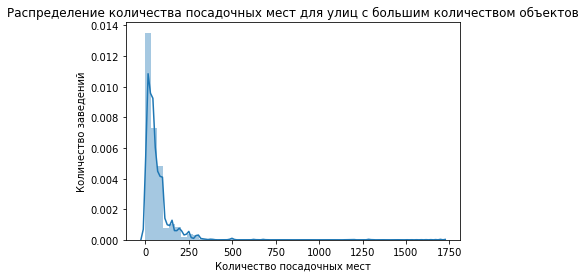

In [39]:
ax = sns.distplot(top_10_count_on_district['number'], bins = 50) 
ax.set(xlabel = 'Количество посадочных мест', ylabel ='Количество заведений', 
       title='Распределение количества посадочных мест для улиц с большим количеством объектов')
plt.show()

Есть выбросы, исключу заведения с количеством посадочным мест более 250.

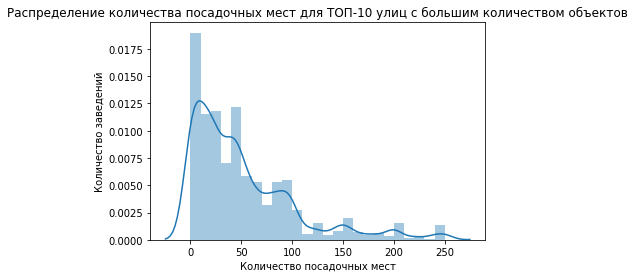

In [40]:
top_10_number = top_10_count_on_district[top_10_count_on_district['number'] <= 250]
ax = sns.distplot(top_10_number['number'], bins=25)
ax.set(xlabel = 'Количество посадочных мест', ylabel ='Количество заведений', 
       title='Распределение количества посадочных мест для ТОП-10 улиц с большим количеством объектов')
plt.show()

Больше всего заведений без посадочных мест, работающих на заказы "с собой" или доставку, затем примерно одинаковое кол-во заведений имеют по 10, 20 и 40 мест, далее идет плавный спад.

### Общие выводы:

Мы выяснили, что большую долю заведений в Москве составляют кафе(их почти в 2.5 раза больше, чем остальных заведений), столовые, рестораны и фастфуд, при этом, доля сетевых заведений всего 20% от общего количества. 

Наиболее характерно сетевое распространение для фастфуда, кулинарии и ресторанов.
А также для сетей характерно иметь много заведений с небольшим количеством посадочных мест.

Найдены топ-10 улиц с наибольшим количеством заведений. 
Больше всего заведений, находящихся на улицах из топа, не имеют посадочных мест.
А если посадочные места есть, то чаще всего их около 10, 20 или 40.

**Рекомендации:**
1. Открыть кафе, так как это самый популярный вид заведений общественного питания.
2. Расположить его на одной из улиц из списка топ-10.
3. Количеств посадочных мест до 40.
4. Как возможности для развития можно рассмотреть открытие заведений с работой на доставку или заказы “с собой”, либо открытие ресторана/столовой с бОльшим количеством посадочных мест, а также развитие сети таких заведений.

## Презентация

https://docs.google.com/presentation/d/1R_Ov25RpFiDpnJdMxIN6TeJJ7aMU9RY_f3tsVjvKs5Q/edit?usp=sharing